<a href="https://colab.research.google.com/github/VitalyGladyshev/gb_pytorch/blob/main/HW_03_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ДЗ 3 Pytorch

## Задание 1

Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Наличие графиков обязательно

In [3]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [ ]:
x = np.linspace(-15, 15, 1001)

In [ ]:
if 0 in x:
    print("Есть 0")

Есть 0


In [ ]:
def func_y(x):    
    if 0 in x:
        x[x == 0] = 0.00001
    return np.sin(x)/x - x/10 

In [ ]:
y = func_y(x)

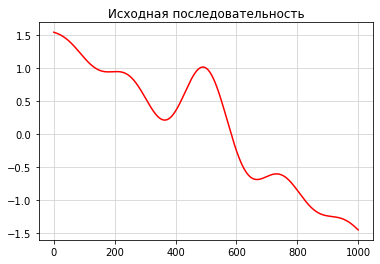

In [ ]:
plt.plot(y, 'r')

plt.grid(color="lightgrey")
plt.title('Исходная последовательность' )
plt.show()

In [ ]:
class Inc_Dataset(Dataset):
    def __init__(self, b_border, u_border, point_number):
        x = np.linspace(b_border, u_border, point_number)
        if 0 in x:
            x[x == 0] = 0.00001
        self.data = x
        self.labels = np.sin(x)/x - x/10


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = self.data[idx]
        label = self.labels[idx]
        return (item, label)

In [ ]:
dataset = Inc_Dataset(-15, 15, 1001)

In [ ]:
split_train_part = 0.75
batch_size = 16

real_data_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                            [int(split_train_part*dataset.data.shape[0]), 
                                                             dataset.data.shape[0] - int(split_train_part*dataset.data.shape[0])])
real_data_loader = DataLoader(real_data_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


### Генератор

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)
        # self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # self.sph = nn.Softplus()

    def forward(self, x):
        # print("X размеры in: %s\n" % (x.shape,))
        x = self.tanh(self.fc1(x))
        # print("X размеры in: %s\n" % (x.shape,))
        x = self.tanh(self.fc2(x))
        # x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        # print("X размеры in: %s\n" % (x.shape,))
        return x

### Дискриминатор 

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        # self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        self.sigm = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        # self.sfm = nn.Softmax()

    def forward(self, x):
        # print("X размеры d in: %s\n" % (x.shape,))
        x = self.relu(self.fc1(x))
        # print("X размеры fc1 sigm in: %s\n" % (x.shape,))
        x = self.relu(self.fc2(x))
        # x = self.relu(self.fc3(x))
        x = self.sigm(self.fc4(x))
        return x

### Инициализация

In [ ]:
n_epochs = 1000
lr = 0.0001   # 0.0005

b1 = 0.5
b2 = 0.999

sample_interval = 50

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))   # torch.optim.SGD(generator.parameters(), lr=lr, momentum=0.9)   # 
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))   # torch.optim.SGD(discriminator.parameters(), lr=lr, momentum=0.9)   # 

adversarial_loss = torch.nn.BCELoss()   # nn.CrossEntropyLoss() 

In [ ]:
d_loss_history = []
g_loss_history = []

In [ ]:
idx = torch.randperm(16)
idx

tensor([ 5,  0, 12, 10,  1, 11,  6, 15,  2, 14, 13,  7,  3,  4,  8,  9])

In [ ]:
for epoch in range(1):
    for i, (number, labels) in enumerate(real_data_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_number = Variable(number.type(torch.FloatTensor)).to(device)

        #генерация шума
        idx = torch.randperm(batch_size)
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        print(f"real_number: {real_number}")
        # print(f"{z.shape}")
        print(f"z: {z.view(16, 1)}")
        print(f"{z.view(16, 1).shape}")
        # print(f"z: {z}")
        # print(f"real_number + z: {real_number + z}")
        print(f"valid.shape: {valid.shape}")
        print(f"fake.shape: {fake.shape}")

        break
    break

real_number: tensor([  3.8700,   1.2600,  -2.8500,   7.2300,  -1.9800,  13.9800,   7.2900,
         -7.6500, -10.0200, -12.0900,   6.9300,   2.2800,   6.4200,  -6.5700,
          0.7800,   2.4600])
z: tensor([[  2.2800],
        [ -2.8500],
        [  6.9300],
        [  7.2900],
        [ -1.9800],
        [  6.4200],
        [-10.0200],
        [  0.7800],
        [  7.2300],
        [  2.4600],
        [ 13.9800],
        [ -6.5700],
        [ -7.6500],
        [-12.0900],
        [  3.8700],
        [  1.2600]])
torch.Size([16, 1])
valid.shape: torch.Size([16, 1])
fake.shape: torch.Size([16, 1])


[Epoch 498/500] [Batch 44/47] [D loss: 0.666507] [G loss: 0.718898]


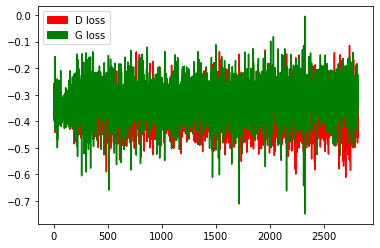

In [ ]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

g_loss_p = 1000
ep_loss = 0
n_epochs = 500

for epoch in range(n_epochs):
    for i, (number, labels) in enumerate(real_data_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(len(number), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(len(labels), 1).fill_(0.0), requires_grad=False).to(device)

        real_numbers = Variable(number.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        idx = torch.randperm(len(number))
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        gen_numbers = generator(z.view(len(z), 1))

        validity = discriminator(gen_numbers)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

        if g_loss < g_loss_p:
            torch.save(generator.state_dict(), "series_gan_loss_min.pth")
            g_loss_p = g_loss
            ep_loss = epoch

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(labels.view(len(labels), 1).type(torch.FloatTensor).to(device))
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_numbers.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

        batches_done = epoch * len(real_data_loader) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            # sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data_loader), d_loss.item(), g_loss.item()) ) 
            
            # display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

In [ ]:
torch.save(generator.state_dict(), "series_gan.pth")

In [ ]:
generator_r = Generator().to(device)
generator_r.load_state_dict(torch.load("series_gan_loss_min.pth"))

<All keys matched successfully>

In [ ]:
x =  np.linspace(-15, 15, 50)
xt = torch.from_numpy(x).type(torch.FloatTensor).to(device)
xt.type()

'torch.FloatTensor'

In [ ]:
gen_numbers = generator_r(xt.view(len(x), 1))

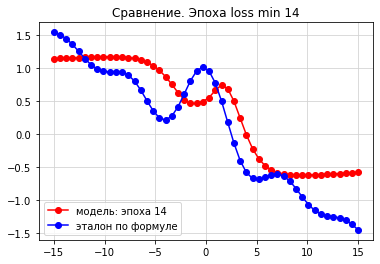

In [ ]:
plt.plot(x, gen_numbers.detach().cpu().numpy(), 'ro-', label=f"модель: эпоха {ep_loss}")
plt.plot(x, func_y(x), 'bo-', label=f"эталон по формуле")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title(f'Сравнение. Эпоха loss min {ep_loss}' )
plt.show()

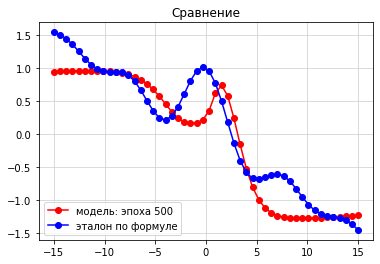

In [ ]:
generator_f = Generator().to(device)
generator_f.load_state_dict(torch.load("series_gan.pth"))

gen_numbers_f = generator_f(xt.view(len(x), 1))

plt.plot(x, gen_numbers_f.detach().cpu().numpy(), 'ro-', label=f"модель: эпоха {n_epochs}")
plt.plot(x, func_y(x), 'bo-', label=f"эталон по формуле")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title('Сравнение' )
plt.show()

### Тестовый dataset


In [ ]:
x_test = []
y_test = []

for x, y in test_loader:
    x_test.append(x), y_test.append(y)

In [ ]:
xt = torch.FloatTensor(x_test).to(device)
gen_numbers_t = generator_f(xt.view(len(x_test), 1))

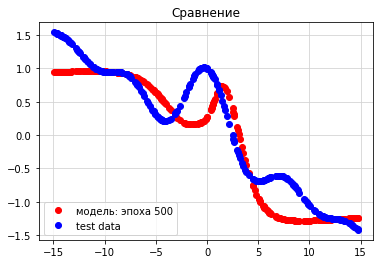

In [ ]:
plt.plot(x_test, gen_numbers_t.detach().cpu().numpy(), 'ro', label=f"модель: эпоха {n_epochs}")
plt.plot(x_test, y_test, 'bo', label=f"test data")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title('Сравнение' )
plt.show()

## Задание 2

Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

In [4]:
# thr_num = 8
batch_sz = 4

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

In [6]:
mnist_train = datasets.MNIST(root='./MNIST/train', 
                                         train=True, 
                                         download=True, 
                                         transform=transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train,
                                                 batch_size=batch_sz,
                                                 shuffle=True)

mnist_test = datasets.MNIST(root='./MNIST/test', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test,
                                                batch_size=batch_sz,
                                                shuffle=False)

Extracting ./MNIST/train/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/train/MNIST/raw


Extracting ./MNIST/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/train/MNIST/raw



Extracting ./MNIST/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/train/MNIST/raw


Extracting ./MNIST/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/train/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./MNIST/test/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/test/MNIST/raw




Extracting ./MNIST/test/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/test/MNIST/raw


Extracting ./MNIST/test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/test/MNIST/raw


Extracting ./MNIST/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/test/MNIST/raw
Processing...
Done!


In [7]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

images размеры view: torch.Size([4, 1, 28, 28])

imgs размеры view: torch.Size([3, 32, 122])

GroundTruth:
        5        1        7        3







Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


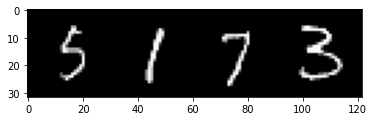

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images размеры view: torch.Size([4, 1, 28, 28])

imgs размеры view: torch.Size([3, 32, 122])

GroundTruth:
        0        8        5        6


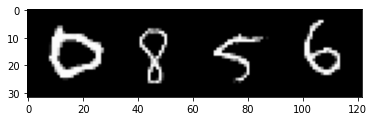

In [8]:
data_iter = iter(mnist_train_loader)
# [data_iter.next() for i in range(0)]

for i in range(2):
    images, labels = data_iter.next()

    print("images размеры view: %s\n" % (images.shape, ))
    
    imgs = make_grid(images)
    print("imgs размеры view: %s\n" % (imgs.shape,))
    print('GroundTruth:\n', ' '.join('%8s' % classes[labels[j]] for j in range(batch_sz)))
    plt.imshow(imgs.permute(1, 2, 0).numpy())
    plt.show()

### Генераторы

In [25]:
latent_dim = 100 # 128
batch_sz = 32

In [26]:
class Generator_1(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.activation = nn.ModuleDict({'lrelu': nn.LeakyReLU(0.2, inplace=True), 
                                        'relu': nn.ReLU(0.2)})
        
#         self.activations = nn.ModuleDict([
#                 ['lrelu', nn.LeakyReLU()],
#                 ['relu', nn.ReLU()]])
        
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [27]:
class Generator_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [194]:
class Generator_3(nn.Module):
    def __init__(self, nn_prn=False):
        super(Generator_3, self).__init__()

        self.nn_prn = nn_prn

        self.fc_dec1 = nn.Linear(latent_dim, 7*7*1024)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.conv2_transp_1 = nn.ConvTranspose2d(latent_dim, 1024, kernel_size=4, stride=(2, 2), padding=(1, 1)) #, output_padding=1)
        # nn.init.normal_(self.conv2_transp_1.weight.data, 0.0, 0.02)
        self.conv2_transp_2 = nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=(2, 2), padding=(1, 1)) #, output_padding=1)
        # nn.init.normal_(self.conv2_transp_2.weight.data, 0.0, 0.02)
        self.conv2_1 = nn.Conv2d(256, 1, kernel_size=7, padding=(3, 3))
        # nn.init.normal_(self.conv2_1.weight.data, 0.0, 0.02)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        if self.nn_prn:
            print("Генератор\n")
            print("\tразмеры income: %s\n" % (x.shape,))
        x = x.view(-1, latent_dim)
        if self.nn_prn:
            print("\tразмеры x.view: %s\n" % (x.shape,))
        x = self.leaky_relu(self.fc_dec1(x))
        if self.nn_prn:
            print("\tразмеры fc_dec1, leaky_relu: %s\n" % (x.shape,))
        x = x.view(-1, latent_dim, 7, 7)
        if self.nn_prn:
            print("\tразмеры x.view: %s\n" % (x.shape,))
        x = self.leaky_relu(self.conv2_transp_1(x))
        if self.nn_prn:
            print("\tразмеры conv2_transp_1, leaky_relu: %s\n" % (x.shape,))
        x = self.leaky_relu(self.conv2_transp_2(x))
        if self.nn_prn:
            print("\tразмеры conv2_transp_2, leaky_relu: %s\n" % (x.shape,))
        x = self.sigm(self.conv2_1(x))
        if self.nn_prn:
            print("\tразмеры conv2_1, sigm: %s\n" % (x.shape,))
        x = x.view(-1, 1, 28, 28)
        if self.nn_prn:
            print("\tразмеры x.view: %s\n" % (x.shape,))
            self.nn_prn = False
        return x

In [57]:
class Generator_4(nn.Module):
    def __init__(self, ngpu):
        super(Generator_4, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

### Дискриминаторы

In [30]:
class Discriminator_1(nn.Module):
    def __init__(self):
        super(Discriminator_1, self).__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [31]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias) 

In [32]:
class Discriminator_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [195]:
class Discriminator_3(nn.Module):
    def __init__(self, nn_prn=False):
        super(Discriminator_3, self).__init__()

        self.nn_prn = nn_prn

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=(2, 2), padding=(1, 1))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=(2, 2), padding=(1, 1))
        self.gpool = nn.MaxPool2d(kernel_size=7)
        self.fc_out = nn.Linear(32, 1)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        if self.nn_prn:
            print("Дискриминатор\n")
            print("\tразмеры income: %s\n" % (x.shape,))
        x = x.view(-1, 1, 28, 28)
        if self.nn_prn:
            print("\tразмеры x.view: %s\n" % (x.shape,))
        x = self.leaky_relu(self.conv1(x))
        if self.nn_prn:
            print("\tразмеры conv1, leaky_relu: %s\n" % (x.shape,))
        x = self.leaky_relu(self.conv2(x))
        if self.nn_prn:
            print("\tразмеры conv2, leaky_relu: %s\n" % (x.shape,))
        x = self.gpool(x)
        if self.nn_prn:
            print("\tразмеры gpool: %s\n" % (x.shape,))
        x = x.view(-1, 32)
        if self.nn_prn:
            print("\tразмеры x.view: %s\n" % (x.shape,))
        x = self.sigm(self.fc_out(x))
        if self.nn_prn:
            print("\tразмеры sigm fc_out: %s\n" % (x.shape,))
            self.nn_prn = False
        return x

In [34]:
class Discriminator_4(nn.Module):
    def __init__(self, cnn_filt_num=64, kern_size=5, func_act='relu', in_shape=28, nn_prn=False):
        super(Discriminator_4, self).__init__()

        self.nn_prn = nn_prn
        
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()

        self.conv1 = nn.Conv2d(1, cnn_filt_num, kernel_size=kern_size, stride=1, padding=(2, 2))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(cnn_filt_num, cnn_filt_num*2, kernel_size=kern_size, stride=1, padding=(2, 2))
        cnn_filt_num *= 2
        
        self.fs_size = cnn_filt_num * (in_shape//2**2) ** 2
        fs_sz = self.fs_size
        
        self.fc_dec1 = nn.Linear(fs_sz, fs_sz//4)   # fs_sz*3//4
        fs_sz=fs_sz//4   # *3//4
        self.fc_out = nn.Linear(fs_sz, 1)

    def forward(self, x):
        if self.nn_prn:
            print("Дискриминатор\n")
            print("\tразмеры income: %s\n" % (x.shape,))
        x = x.view(-1, 1, 28, 28)
        if self.nn_prn:
            print("\tразмеры x.view: %s\n" % (x.shape,))
        x = self.pool(self.relu(self.conv1(x)))
        if self.nn_prn:
            print("\tразмеры conv1, pool: %s\n" % (x.shape,))
        x = self.pool(self.relu(self.conv2(x)))
        if self.nn_prn:
            print("\tразмеры conv2, pool: %s\n" % (x.shape,))

        x = x.view(-1, self.fs_size)
        if self.nn_prn:
            print("\tразмеры x.view: %s\n" % (x.shape,))
        x = self.relu(self.fc_dec1(x))
        if self.nn_prn:
            print("\tразмеры fc_dec1: %s\n" % (x.shape,))
        x = self.sigm(self.fc_out(x))
        if self.nn_prn:
            print("\tразмеры fc_out: %s\n" % (x.shape,))
            self.nn_prn = False
        return x

In [80]:
class Discriminator_5(nn.Module):
    def __init__(self, ngpu, nn_prn=False):
        super(Discriminator_5, self).__init__()
        self.ngpu = ngpu
        self.nn_prn = nn_prn

        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if self.nn_prn:
            print("\tразмеры input: %s\n" % (input.shape,))
        output = self.main(input)
        if self.nn_prn:
            print("\tразмеры input: %s\n" % (output.shape,))
            self.nn_prn = False
        return output

### Инициализация

In [36]:
n_epochs = 50
lr = 0.0003   # 0.0005

b1 = 0.5
b2 = 0.999

img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [38]:
mnist_train = datasets.MNIST(root='./MNIST/train', 
                                         train=True, 
                                         download=True, 
                                         transform=transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train,
                                                 batch_size=batch_sz,
                                                 shuffle=True)

In [39]:
generator = Generator_2().to(device)   # nn_prn=True
discriminator = Discriminator_2().to(device)   # nn_prn=True

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)   # , betas=(b1, b2))   # torch.optim.SGD(generator.parameters(), lr=lr, momentum=0.9)   # 
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)   # , betas=(b1, b2))   # torch.optim.SGD(discriminator.parameters(), lr=lr, momentum=0.9)   # 

adversarial_loss = torch.nn.BCELoss()   # nn.CrossEntropyLoss() 

In [40]:
d_loss_history = []
g_loss_history = []

In [41]:
######## функция для вывода изображения ########
def sample_image(static_sample):
    npimg = make_grid(static_sample.data).cpu().numpy()
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    plt.show()

[Epoch 49/50] [Batch 1800/1875] [D loss: 0.641436] [G loss: 0.833901]


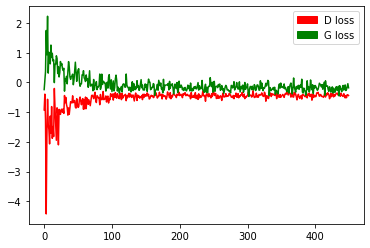

In [42]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

g_loss_p = 1000
ep_loss = 0

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(mnist_train_loader):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

        if g_loss < g_loss_p:
            torch.save(generator.state_dict(), f"conv_test_gan_loss_min_g2_d2_ep{epoch}_gloss{g_loss}.pth")
            g_loss_p = g_loss
            ep_loss = epoch

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

        batches_done = epoch * len(mnist_train_loader) + i
    
        if (i+1) % 200 == 0:
            plt.clf()
            
            display.clear_output(wait=False)

            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i+1, len(mnist_train_loader), d_loss.item(), g_loss.item()) ) 
            # sample_image(gen_numbers)            
            # display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

In [43]:
torch.save(generator.state_dict(), "series_g2_d2_e50.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

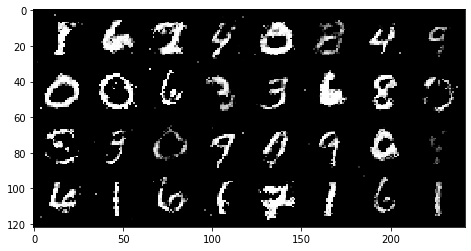

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

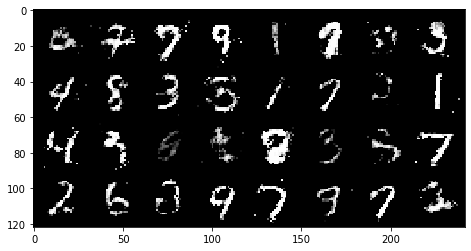

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

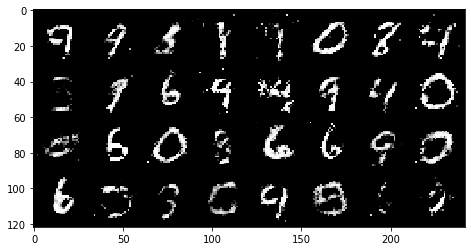

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

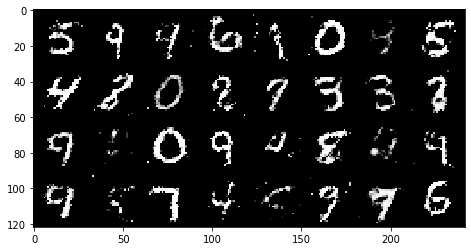

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

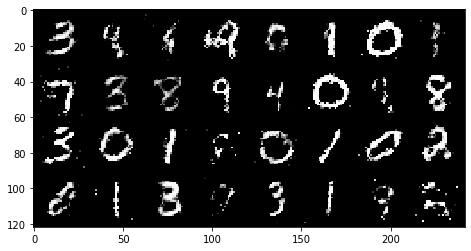

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

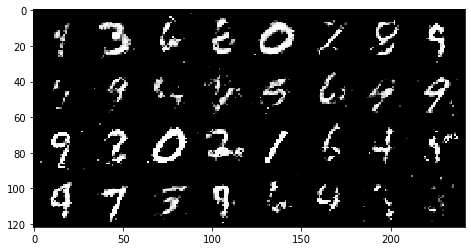

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

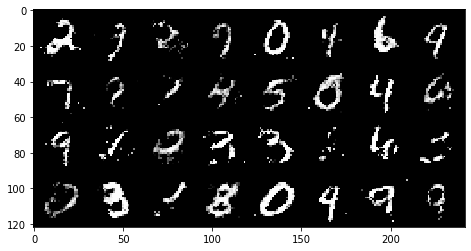

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

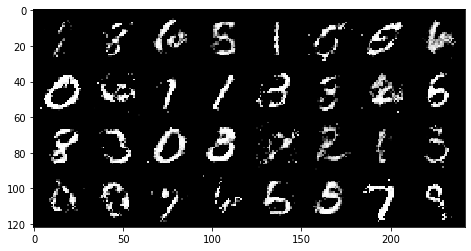

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

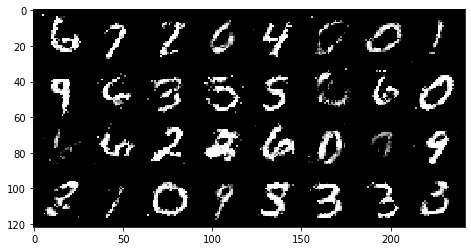

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

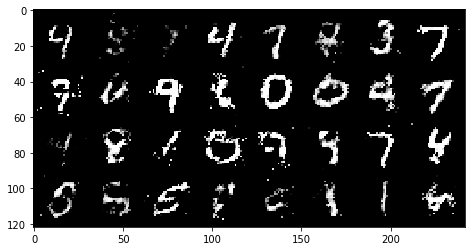

In [44]:
for it in range(10):
    #генерация шума
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

    gen_numbers = generator(z)

    plt.clf()

    # display.clear_output(wait=False)
    sample_image(gen_numbers)
    # display.display(plt.gcf())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

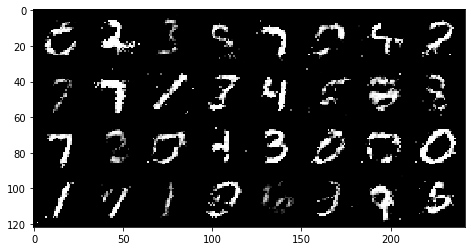

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

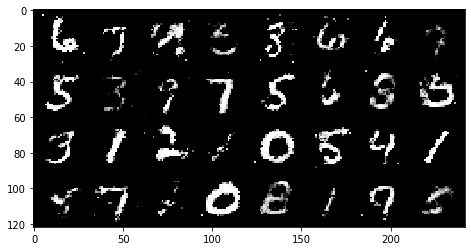

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

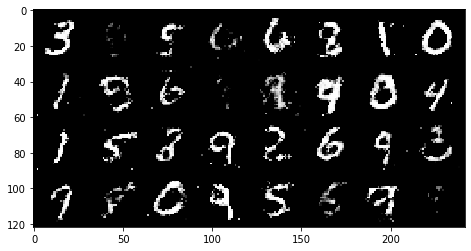

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

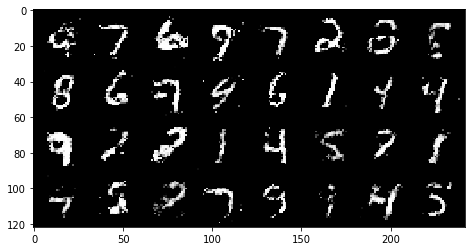

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

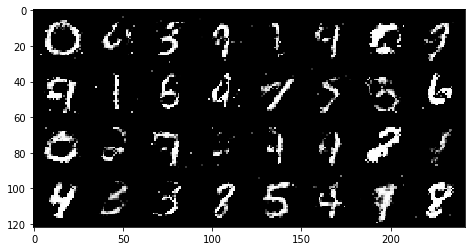

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

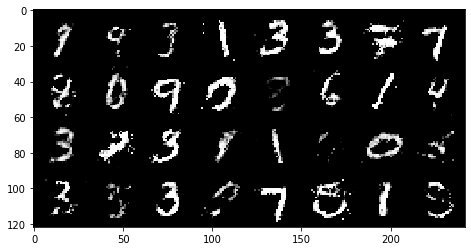

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

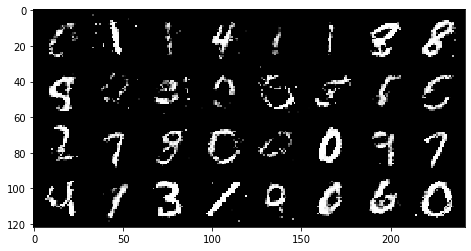

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

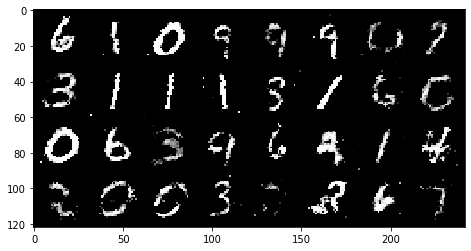

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

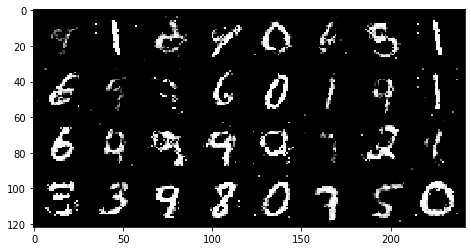

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

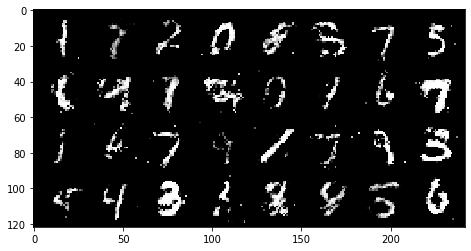

In [46]:
generator_f_min_l = Generator_2().to(device)
generator_f_min_l.load_state_dict(torch.load(f"/content/conv_test_gan_loss_min_g2_d2_ep0_gloss0.11939599364995956.pth"))

for it in range(10):
    #генерация шума
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

    gen_numbers = generator(z)

    plt.clf()

    # display.clear_output(wait=False)
    sample_image(gen_numbers)

### Адаптированный вариант из туториала :)

In [122]:
import random

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [123]:
# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [124]:
transform_2 = transforms.Compose(
    [transforms.Resize(image_size), 
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

In [125]:
mnist_train = datasets.MNIST(root='./MNIST/train', 
                                         train=True, 
                                         download=True, 
                                         transform=transform_2)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train,
                                                 batch_size=batch_size,
                                                 shuffle=True)

In [128]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [129]:
generator = Generator_4(ngpu).to(device)
generator.apply(weights_init)

# Print the model
print(generator)

Generator_4(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


In [130]:
discriminator = Discriminator_5(ngpu, nn_prn=True).to(device)

discriminator.apply(weights_init)
# Print the model
print(discriminator)

Discriminator_5(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [131]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

adversarial_loss = torch.nn.BCELoss()

In [132]:
for epoch in range(2):
    for i, (imgs, labels) in enumerate(mnist_train_loader):
        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)
        print(real_imgs.shape)
        break
    break

torch.Size([32, 1, 64, 64])


[Epoch 4/50] [Batch 1800/1875] [D loss: 0.011662] [G loss: 5.781490]


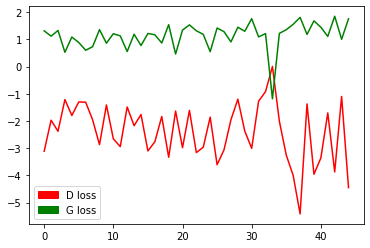

In [112]:
d_loss_history = []
g_loss_history = []

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

g_loss_p = 1000
ep_loss = 0

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(mnist_train_loader):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
        fake = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.randn(batch_size, nz, 1, 1, device=device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs).view(-1)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

        if g_loss < g_loss_p:
            torch.save(generator.state_dict(), f"conv_test_gan_loss_min_g4_d5_ep{epoch}_gloss{g_loss:.4f}.pth")
            g_loss_p = g_loss
            ep_loss = epoch

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs).view(-1)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach()).view(-1)
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

        batches_done = epoch * len(mnist_train_loader) + i
    
        if (i+1) % 200 == 0:
            plt.clf()
            
            display.clear_output(wait=False)

            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, num_epochs, i+1, len(mnist_train_loader), d_loss.item(), g_loss.item()) ) 

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

In [113]:
torch.save(generator.state_dict(), "series_g4_d5_e5.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

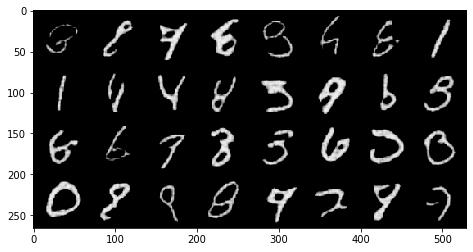

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

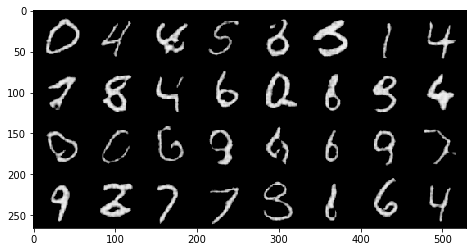

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

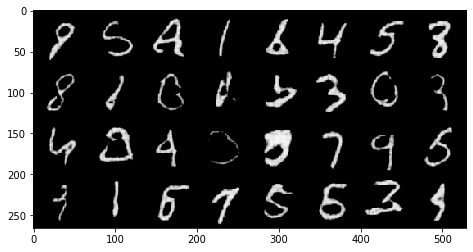

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

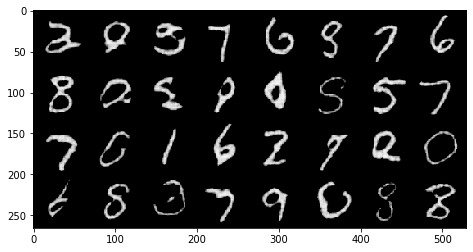

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

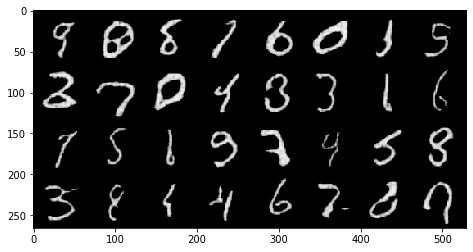

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

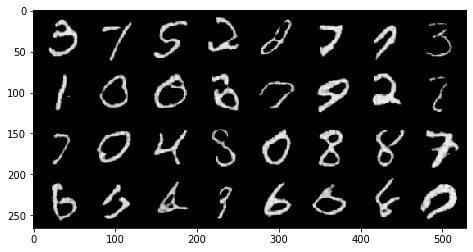

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

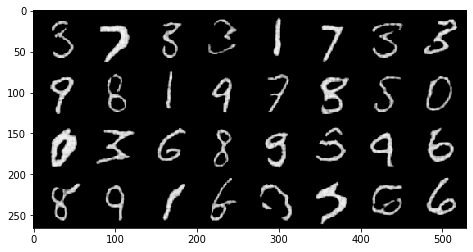

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

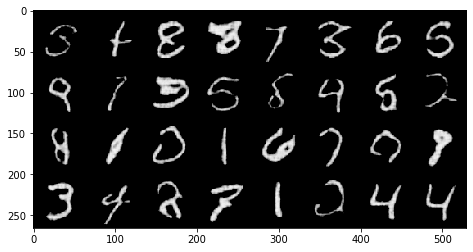

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

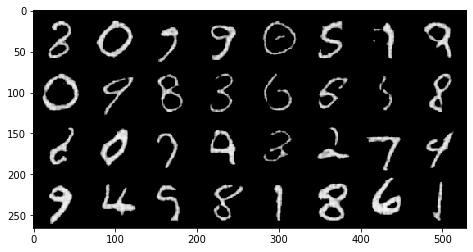

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

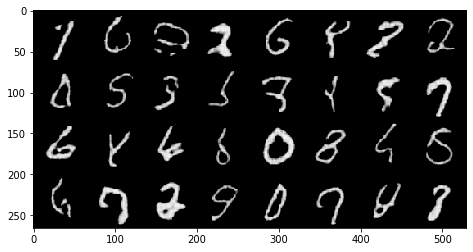

In [114]:
for it in range(10):
    #генерация шума
    z = torch.randn(batch_size, nz, 1, 1, device=device)

    gen_numbers = generator(z)

    plt.clf()

    # display.clear_output(wait=False)
    sample_image(gen_numbers)
    # display.display(plt.gcf())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

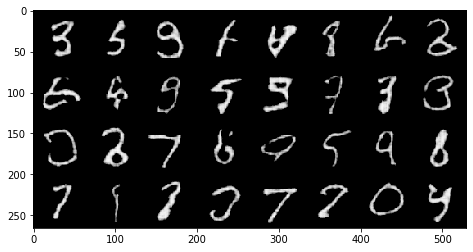

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

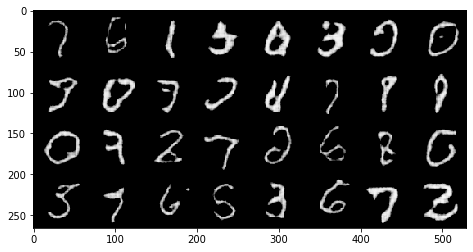

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

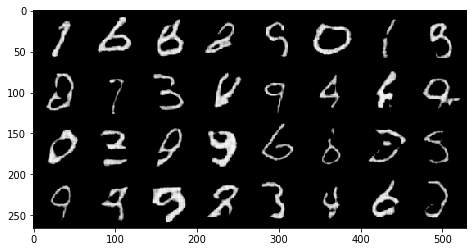

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

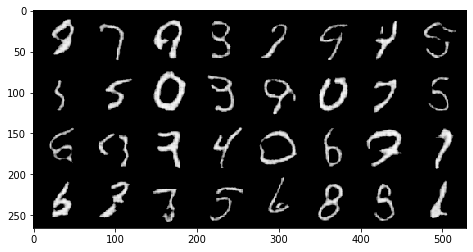

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

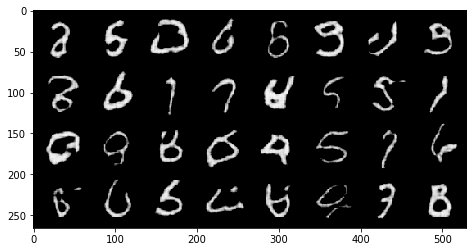

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

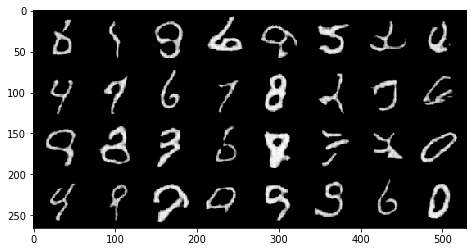

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

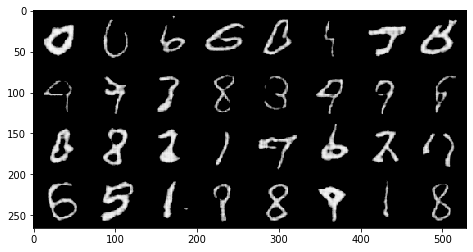

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

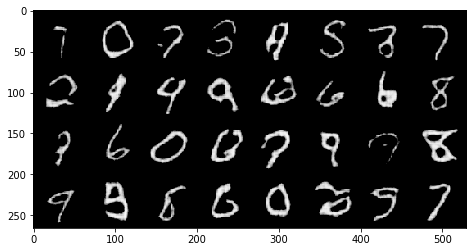

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

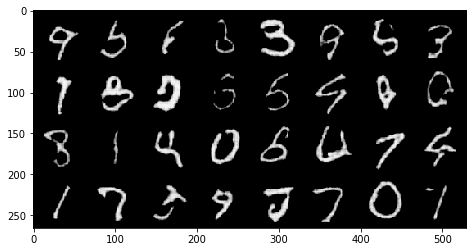

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

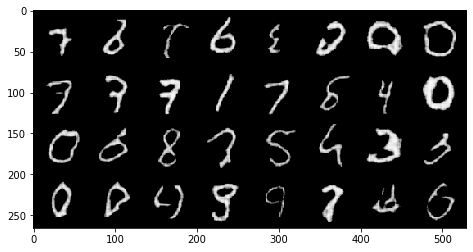

In [143]:
generator_f_min_l = Generator_4(ngpu).to(device)
generator_f_min_l.load_state_dict(torch.load(f"/content/conv_test_gan_loss_min_g4_d5_ep3_gloss0.0003.pth"))

for it in range(10):
    #генерация шума
    z = torch.randn(batch_size, nz, 1, 1, device=device)

    gen_numbers = generator_f_min_l(z)

    plt.clf()

    # display.clear_output(wait=False)
    sample_image(gen_numbers)

### Попытка использовать свои Г и Д

In [229]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

In [230]:
n_epochs = 7
lr = 0.0003   # 0.0005

b1 = 0.5
b2 = 0.999

img_size = 28
channels = 1

sample_interval = 25
batch_sz = 32

img_shape = (channels, img_size, img_size)

In [231]:
mnist_train = datasets.MNIST(root='./MNIST/train', 
                                         train=True, 
                                         download=True, 
                                         transform=transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train,
                                                 batch_size=batch_sz,
                                                 shuffle=True)

In [232]:
generator = Generator_2().to(device)   # nn_prn=True
discriminator = Discriminator_3(nn_prn=True).to(device)   # nn_prn=True

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)   # , betas=(b1, b2))   # torch.optim.SGD(generator.parameters(), lr=lr, momentum=0.9)   # 
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)   # , betas=(b1, b2))   # torch.optim.SGD(discriminator.parameters(), lr=lr, momentum=0.9)   # 

adversarial_loss = torch.nn.BCELoss()   # nn.CrossEntropyLoss() 

In [148]:
# for epoch in range(2):
#     for i, (imgs, labels) in enumerate(mnist_train_loader):
#         real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)
#         print(real_imgs.shape)
#         break
#     break

torch.Size([32, 1, 28, 28])


[Epoch 7/7] [Batch 1800/1875] [D loss: 0.819789] [G loss: 0.581226]


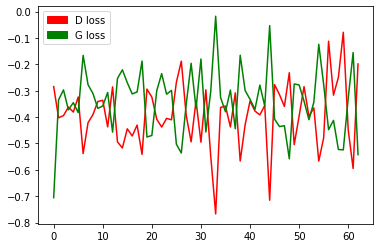

In [233]:
latent_dim = 100

d_loss_history = []
g_loss_history = []

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

g_loss_p = 1000
ep_loss = 0

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(mnist_train_loader):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

        if g_loss < g_loss_p:
            torch.save(generator.state_dict(), f"conv_test_gan_loss_min_g2_d3_ep{epoch}_gloss{g_loss:.4f}.pth")
            g_loss_p = g_loss
            ep_loss = epoch

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

        batches_done = epoch * len(mnist_train_loader) + i
    
        if (i+1) % 200 == 0:
            plt.clf()
            
            display.clear_output(wait=False)

            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch+1, n_epochs, i+1, len(mnist_train_loader), d_loss.item(), g_loss.item()) ) 
            # sample_image(gen_numbers)            
            # display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

In [234]:
torch.save(generator.state_dict(), "series_g2_d3_e7.pth")